# MA755 - Team Sandbox

Material from

> "[Hands-On Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do)"<br>
by Aurélien Géron
Published by O'Reilly Media, Inc., 2017

Annotations, comments, and implementation on dataset by Angela Su, Tyler Miguel, Sebastian Bury

to do

- Import data
- shrink photos
- train/label (might need to handcode these)
- train model
- get features
- predict on test
- conclude

# Load Libraries 

In [2]:
from __future__ import division, print_function, absolute_import
from skimage import color, io
from scipy.misc import imresize
import numpy as np
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
from sklearn.model_selection import train_test_split
import os
from glob import glob

In [ ]:
# might need to use tensor flow libraries

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.metrics import Accuracy

# Import Data

In [3]:
files_path = 'datasets/catsndogs/train/'

In [4]:
cat_files_path = os.path.join(files_path, 'cat.*.jpg')
dog_files_path = os.path.join(files_path, 'dog.*.jpg')

In [5]:
cat_files_path

'datasets/catsndogs/train/cat.*.jpg'

In [6]:
cat_files = sorted(glob(cat_files_path))
dog_files = sorted(glob(dog_files_path))

In [7]:
n_files = len(cat_files) + len(dog_files)
print(n_files)

25000


# Take a look at the data

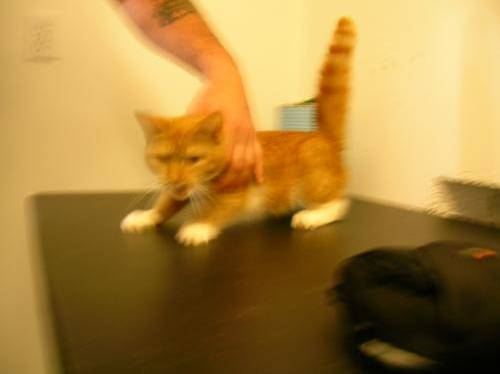

In [8]:
from IPython.display import Image 
Image(filename=files_path+'/cat.0.jpg')

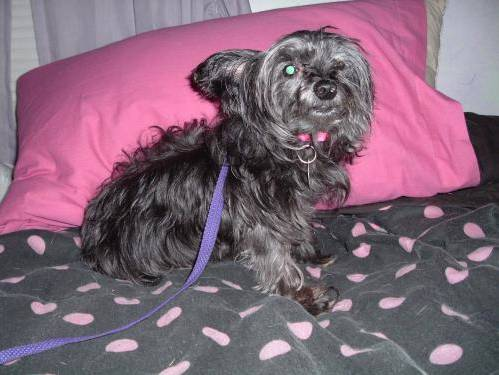

In [9]:
Image(filename=files_path+'/dog.0.jpg')

# resize images

In [49]:
size_image = 28

allX = np.zeros((n_files, size_image, size_image, 3), dtype='float32')
ally = np.zeros(n_files, dtype='int32')
count = 0
for f in cat_files:
    try:
        img = io.imread(f)
        new_img = imresize(img, (size_image, size_image, 3))
        allX[count] = np.array(new_img)
        ally[count] = 0
        count += 1
    except:
        continue

In [50]:
for f in dog_files:
    try:
        img = io.imread(f)
        new_img = imresize(img, (size_image, size_image, 3))
        allX[count] = np.array(new_img)
        ally[count] = 1
        count += 1
    except:
        continue

# simple example of creating one convoluted layer

In [11]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

In [12]:
np.array(allX[0:2], dtype=np.float32).shape

(2, 28, 28, 3)

In [13]:
data_point = np.array(allX[0:2], dtype=np.float32)
batch_size, height, width, channels = (data_point.shape)

In [14]:
# Create 2 filters
import tensorflow as tf

filters_test = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32) 
filters_test[:, 3, :, 0] = 1 # vertical line
filters_test[3, :, :, 1] = 1 # horizontal line

In [15]:
# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters_test, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: data_point})

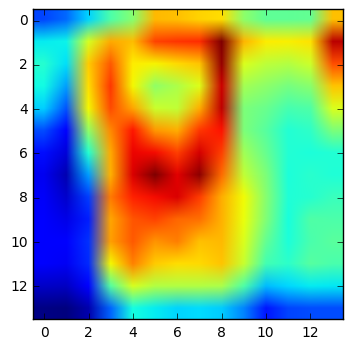

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.imshow(output[1, :, :, 0]) #plot 1st image's 2nd feature map 
plt.show()

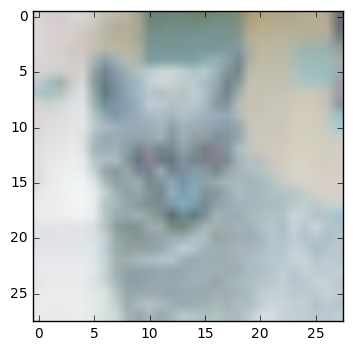

In [17]:
plt.imshow(allX[1])
plt.show()

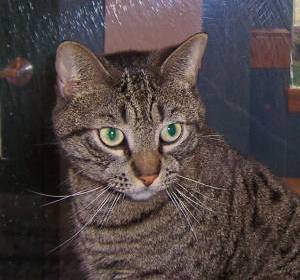

In [19]:
from IPython.display import Image 
Image(filename='train/cat.1.jpg')

# simple example of creating one pooling layer

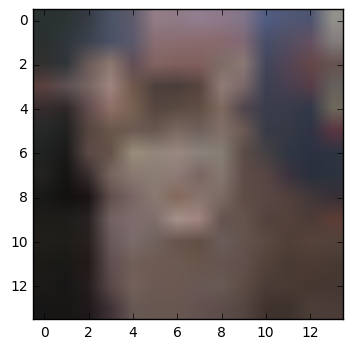

In [20]:
# Create a graph with input X plus a max pooling layer
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: data_point})

plt.imshow(output[1].astype(np.uint8)) # plot the output for the 1st image 
plt.show()

# split the data

In [21]:
from tensorflow.contrib.layers import fully_connected

In [51]:
X, X_test, Y, Y_test = train_test_split(allX, ally, test_size=0.1, random_state=42)

In [ ]:
# from google https://www.tensorflow.org/tutorials/layers

In [52]:
tf.reset_default_graph()

def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features, [-1, 28, 28, 3])
    
    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    # Dense Layer
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense, rate=0.4, training=mode == learn.ModeKeys.TRAIN)
    
    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=2)
    
    loss = None
    train_op = None
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    if mode != learn.ModeKeys.INFER:
        onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=2)
        loss = tf.losses.softmax_cross_entropy(
            onehot_labels=onehot_labels, logits=logits)
        
    # Configure the Training Op (for TRAIN mode)
    if mode == learn.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss=loss,
            global_step=tf.contrib.framework.get_global_step(),
            learning_rate=0.001,
            optimizer="SGD")

    # Generate Predictions
    predictions = {
        "classes": tf.argmax(
            input=logits, axis=1),
        "probabilities": tf.nn.softmax(
            logits, name="softmax_tensor")
    }
    # Return a ModelFnOps object
    return model_fn_lib.ModelFnOps(
        mode=mode, predictions=predictions, loss=loss, train_op=train_op)

In [53]:
cd_classifier = learn.Estimator(
      model_fn=cnn_model_fn, model_dir="tempformodel_1/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_evaluation_master': '', '_tf_random_seed': None, '_task_id': 0, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_model_dir': None, '_is_chief': True, '_master': '', '_keep_checkpoint_max': 5, '_environment': 'local', '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13df682b0>, '_num_worker_replicas': 0}


In [54]:
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [55]:
cd_classifier.fit(
    x=X,
    y=Y,
    batch_size=10,
    steps=1000,
    monitors=[logging_hook])

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/Users/tylermiguel/anaconda/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into tempformodel_1/model.ckpt.
INFO:tensorflow:loss = 33.5035, step = 1
INFO:tensorflow:probabilities = [[ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.          1.        ]
 [ 0.99999046  0.00000956]
 [ 0.          1.        ]]
INFO:tensorflow:probabilities = [[ 0.57345474  0.42654532]
 [ 0.68973547  0.31026453]
 [ 0.42418012  0.57581985]
 [ 0.43271071  0.56728929]
 [ 0.53158331  0.46841663]
 [ 0.49066937  0.50933069]
 [ 0.47090369  0.52909631]
 [ 0.34442443  0.65557557]
 [ 0.44369242  0.55630755]
 [ 0.74543875  0.25456125]] (3.791 sec)
INFO:tensorflow:global_step/sec: 13.7665
INFO:tensorflow:loss = 0.548433, step = 101 (7.265 sec)
INFO:tensorflow:probabilities = [[ 0.56656802  0.43343195]
 [ 0.40188652  0.59811348]
 [ 0.56283218  0.43716779]
 [ 0.85340321 

Estimator(params=None)

In [24]:
cd_classifier.

<bound method _BaseEstimator.get_params of Estimator(params=None)>

In [25]:
metrics = {
    "accuracy":
        learn.MetricSpec(
            metric_fn=tf.metrics.accuracy, prediction_key="classes"),
}

In [26]:
eval_results = cd_classifier.evaluate(
    x=X_test, y=Y_test, metrics=metrics)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/Users/tylermiguel/anaconda/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Starting evaluation at 2017-05-10-20:47:18
INFO:tensorflow:Restoring parameters from tempformodel/model.ckpt-1000
INFO:tensorflow:Finished evaluation at 2017-05-10-20:47:25
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.5636, global_step = 1000, loss = 0.68078
{'loss': 0.68077993, 'global_step': 1000, 'accuracy': 0.5636}


In [27]:
print(eval_results)

{'loss': 0.68077993, 'global_step': 1000, 'accuracy': 0.5636}


In [ ]:
print("\nTest Accuracy: {0:f}\n".format(accuracy_score))

In [70]:
predictions = cd_classifier.predict(X_test, as_iterable=True)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


/Users/tylermiguel/anaconda/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Restoring parameters from tempformodel_1/model.ckpt-1000


In [73]:
for i, p in enumerate(predictions):
  print("Prediction %s: Class %s Probability %s" % (i + 1, p["classes"], p["probabilities"]))

Prediction 1: Class 0 Probability [ 0.62251306  0.37748694]
Prediction 2: Class 0 Probability [ 0.55736297  0.44263709]
Prediction 3: Class 0 Probability [ 0.91667616  0.08332388]
Prediction 4: Class 0 Probability [ 0.89033675  0.10966321]
Prediction 5: Class 1 Probability [ 0.42585069  0.57414931]
Prediction 6: Class 1 Probability [ 0.49717304  0.50282699]
Prediction 7: Class 1 Probability [ 0.48388466  0.51611537]
Prediction 8: Class 1 Probability [ 0.49309069  0.50690931]
Prediction 9: Class 1 Probability [ 0.4909493   0.50905073]
Prediction 10: Class 0 Probability [ 0.52315986  0.47684017]
Prediction 11: Class 0 Probability [ 0.66166425  0.33833572]
Prediction 12: Class 1 Probability [ 0.48317069  0.51682925]
Prediction 13: Class 1 Probability [ 0.49717304  0.50282699]
Prediction 14: Class 1 Probability [ 0.49717304  0.50282699]
Prediction 15: Class 0 Probability [ 0.50607538  0.49392459]
Prediction 16: Class 1 Probability [ 0.47798628  0.52201372]
Prediction 17: Class 1 Probabilit